<a href="https://colab.research.google.com/github/Wadya-mp04/NodeJS-Blog/blob/main/notebooks/MLP_472.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms, models
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# -------------------------------------------------
# 1. Load CIFAR-10 full train and test (no transforms)
# -------------------------------------------------
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True)

X_train_all = train_dataset.data                  # (50000, 32, 32, 3), uint8
y_train_all = torch.tensor(train_dataset.targets)     # (50000,), ints

X_test_all  = test_dataset.data                   # (10000, 32, 32, 3)
y_test_all  = torch.tensor(test_dataset.targets)      # (10000,)

class_names = train_dataset.classes
print("Classes:", class_names)
print("Full train shape:", X_train_all.shape)
print("Full test shape:", X_test_all.shape)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Full train shape: (50000, 32, 32, 3)
Full test shape: (10000, 32, 32, 3)


In [ ]:
# -------------------------------------------------
# 2. Take 500 train and 100 test images per class
# -------------------------------------------------

import numpy as np

def select_n_per_class(X, y, n_per_class, n_classes=10):
    X_filtered = []
    y_filtered = []
    class_counts = [0] * n_classes

    for i, label in enumerate(y):
      label = int(label)
      if class_counts[label] < n_per_class:
          X_filtered.append(X[i])
          y_filtered.append(label)
          class_counts[label] += 1
          if sum(class_counts) == n_per_class * n_classes:
              break

    #  lists -> NumPy arrays first (fast)
    X_np = np.stack(X_filtered, axis=0)
    y_np = np.array(y_filtered, dtype=np.int64)

    # NumPy -> torch tensors
    X_t = torch.from_numpy(X_np).permute(0, 3, 1, 2).float()
    y_t = torch.from_numpy(y_np).long()

    return X_t, y_t

X_train, y_train = select_n_per_class(X_train_all, y_train_all, n_per_class=500)
X_test,  y_test  = select_n_per_class(X_test_all,  y_test_all,  n_per_class=100)

print("Train subset:", X_train.shape, y_train.shape)
print("Test subset:",  X_test.shape,  y_test.shape)

Train subset: torch.Size([5000, 3, 32, 32]) torch.Size([5000])
Test subset: torch.Size([1000, 3, 32, 32]) torch.Size([1000])


In [ ]:

# -------------------------------------------------
# 3. Define transform for ResNet-18 (resize + normalize)
# -------------------------------------------------

data_transform = transforms.Compose([
    transforms.ToPILImage(),                       # from NumPy array to PIL image
    transforms.Resize((224, 224)),                 # ResNet-18 expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(                          # ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])


In [ ]:
# -------------------------------------------------
# 4. Load pre-trained ResNet-18 and turn it into a feature extractor
# -------------------------------------------------

resnet18 = models.resnet18(pretrained=True)        # downloads weights if needed
feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])  # drop final layer
feature_extractor.to(device)
feature_extractor.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# -------------------------------------------------
# 5. Function to extract 512-D features for a set of images
# -------------------------------------------------


def extract_features(X, model, transform, device):
    features = []
    with torch.no_grad():
        for img in X:
            img_tensor = transform(img)                # [3, 224, 224]
            img_tensor = img_tensor.unsqueeze(0).to(device)  # [1, 3, 224, 224]
            output = model(img_tensor)                 # [1, 512, 1, 1]
            output = output.view(output.size(0), -1)   # [1, 512]
            features.append(output.cpu().numpy()[0])
    return np.array(features, dtype=np.float64)

train_features = extract_features(X_train, feature_extractor, data_transform, device)
test_features  = extract_features(X_test,  feature_extractor, data_transform, device)

print("Train features shape:", train_features.shape)  # (5000, 512)
print("Test features shape:",  test_features.shape)   # (1000, 512)

Train features shape: (5000, 512)
Test features shape: (1000, 512)


In [ ]:
# -------------------------------------------------
# 6. Use PCA to transform features from 1x512 to 1x50
# -------------------------------------------------


from sklearn.decomposition import PCA

pca = PCA(n_components=50)
train_pca = pca.fit_transform(train_features)   # (5000, 50)
test_pca  = pca.transform(test_features)        # (1000, 50)
# Convert PCA features back to torch tensors
X_train_50 = torch.tensor(train_pca, dtype=torch.float32).to(device)
X_test_50  = torch.tensor(test_pca,  dtype=torch.float32).to(device)

# Move labels to device
y_train = y_train.to(device)
y_test  = y_test.to(device)

print(X_train_50.shape, y_train.shape)  # torch.Size([5000, 50]) torch.Size([5000])
print(X_test_50.shape,  y_test.shape)   # torch.Size([1000, 50]) torch.Size([1000])

torch.Size([5000, 50]) torch.Size([5000])
torch.Size([1000, 50]) torch.Size([1000])


In [ ]:
# -------------------------------------------------
# 7. Build MLP model!
# -------------------------------------------------
class MLP (nn.Module):
  def __init__(self,) :
    super().__init__()
    self.linear_layers = nn.Sequential(
        nn.Linear(50,512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512,10)
    )

  def forward(self,x):
    return self.linear_layers(x)

MLPModel = MLP().to(device)
MLPModel

MLP(
  (linear_layers): Sequential(
    (0): Linear(in_features=50, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
# -------------------------------------------------
# 8. Define loss and optimizer function
# -------------------------------------------------
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = MLPModel.parameters(), lr=0.1,momentum = 0.9)

In [ ]:
# -------------------------------------------------
# 8. Training and testing loop!!!! (for base model, as per document's instructions)
# -------------------------------------------------

epochs = 100

for epoch in range(epochs):
    MLPModel.train()

    logits = MLPModel(X_train_50)      # (5000, 10)
    loss = loss_fn(logits, y_train)    # CrossEntropyLoss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    MLPModel.eval()
    with torch.no_grad():
        # Train accuracy
        train_preds = logits.argmax(dim=1)
        train_acc = (train_preds == y_train).float().mean().item()

        # Test accuracy
        test_logits = MLPModel(X_test_50)
        test_preds = test_logits.argmax(dim=1)
        test_acc = (test_preds == y_test).float().mean().item()

#Keep track of accuracy and lose every 10 epochs
    if(epoch%10==0):
      print(f"Epoch {epoch} | Loss: {loss.item():.4f} | "
            f"Train acc: {train_acc*100:.2f}% | Test acc: {test_acc*100:.2f}%")




Epoch 0 | Loss: 2.3578 | Train acc: 8.80% | Test acc: 24.80%
Epoch 10 | Loss: 0.8833 | Train acc: 69.56% | Test acc: 61.70%
Epoch 20 | Loss: 0.6431 | Train acc: 78.28% | Test acc: 65.90%
Epoch 30 | Loss: 0.4734 | Train acc: 84.90% | Test acc: 66.20%
Epoch 40 | Loss: 0.3305 | Train acc: 91.42% | Test acc: 66.00%
Epoch 50 | Loss: 0.2159 | Train acc: 95.72% | Test acc: 65.60%
Epoch 60 | Loss: 0.1321 | Train acc: 98.70% | Test acc: 65.90%
Epoch 70 | Loss: 0.0786 | Train acc: 99.70% | Test acc: 65.90%
Epoch 80 | Loss: 0.0484 | Train acc: 99.94% | Test acc: 65.70%
Epoch 90 | Loss: 0.0322 | Train acc: 100.00% | Test acc: 65.60%


In [ ]:
# -------------------------------------------------
# 9. Create model with more depth (1 more layer)
# -------------------------------------------------
class MLP1 (nn.Module):
  def __init__(self,) :
    super().__init__()
    self.linear_layers = nn.Sequential(
        nn.Linear(50,512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Linear(512,10)
    )

  def forward(self,x):
    return self.linear_layers(x)

MLP1Model = MLP1().to(device)
MLP1Model

MLP1(
  (linear_layers): Sequential(
    (0): Linear(in_features=50, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
# -------------------------------------------------
# 10. Overwrite old optimizer and loss functions
# -------------------------------------------------
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = MLP1Model.parameters(), lr=0.1,momentum = 0.9)

In [ ]:
# -------------------------------------------------
# 11. Training and testing loop!!!! (for deeper model)
# -------------------------------------------------

epochs = 100

for epoch in range(epochs):
    # ---- TRAIN ----
    MLP1Model.train()

    logits = MLP1Model(X_train_50)      # (5000, 10)
    loss = loss_fn(logits, y_train)    # CrossEntropyLoss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    MLP1Model.eval()
    with torch.no_grad():
        # Train accuracy
        train_preds = logits.argmax(dim=1)
        train_acc = (train_preds == y_train).float().mean().item()

        # Test accuracy
        test_logits = MLP1Model(X_test_50)
        test_preds = test_logits.argmax(dim=1)
        test_acc = (test_preds == y_test).float().mean().item()

#Keep track of accuracy and lose every 10 epochs
    if(epoch%10==0):
      print(f"Epoch {epoch} | Loss: {loss.item():.4f} | "
            f"Train acc: {train_acc*100:.2f}% | Test acc: {test_acc*100:.2f}%")


Epoch 0 | Loss: 2.4011 | Train acc: 12.28% | Test acc: 28.70%
Epoch 10 | Loss: 0.7987 | Train acc: 71.82% | Test acc: 61.50%
Epoch 20 | Loss: 0.4740 | Train acc: 84.50% | Test acc: 65.80%
Epoch 30 | Loss: 0.2168 | Train acc: 95.56% | Test acc: 66.80%
Epoch 40 | Loss: 0.0710 | Train acc: 99.62% | Test acc: 66.50%
Epoch 50 | Loss: 0.0222 | Train acc: 100.00% | Test acc: 66.70%
Epoch 60 | Loss: 0.0096 | Train acc: 100.00% | Test acc: 65.80%
Epoch 70 | Loss: 0.0056 | Train acc: 100.00% | Test acc: 65.80%
Epoch 80 | Loss: 0.0040 | Train acc: 100.00% | Test acc: 65.60%
Epoch 90 | Loss: 0.0032 | Train acc: 100.00% | Test acc: 65.80%


In [ ]:
# -------------------------------------------------
# 12. Smaller layer size? (512 nodes --> 256 nodes)
# -------------------------------------------------
class MLP2 (nn.Module):
  def __init__(self,) :
    super().__init__()
    self.linear_layers = nn.Sequential(
        nn.Linear(50,256),
        nn.ReLU(),
        nn.Linear(256,256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256,10)
    )

  def forward(self,x):
    return self.linear_layers(x)

MLP2Model = MLP2().to(device)
MLP2Model

MLP2(
  (linear_layers): Sequential(
    (0): Linear(in_features=50, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
# -------------------------------------------------
# 13. Overwrite old optimizer and loss functions
# -------------------------------------------------
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = MLP2Model.parameters(), lr=0.1,momentum = 0.9)

In [ ]:
# -------------------------------------------------
# 14. Training and testing loop!!!! (for deeper model)
# -------------------------------------------------

epochs = 100

for epoch in range(epochs):
    # ---- TRAIN ----
    MLP2Model.train()

    logits = MLP2Model(X_train_50)      # (5000, 10)
    loss = loss_fn(logits, y_train)    # CrossEntropyLoss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    MLP2Model.eval()
    with torch.no_grad():
        # Train accuracy
        train_preds = logits.argmax(dim=1)
        train_acc = (train_preds == y_train).float().mean().item()

        # Test accuracy
        test_logits = MLP2Model(X_test_50)
        test_preds = test_logits.argmax(dim=1)
        test_acc = (test_preds == y_test).float().mean().item()

#Keep track of accuracy and lose every 10 epochs
    if(epoch%10==0):
      print(f"Epoch {epoch} | Loss: {loss.item():.4f} | "
            f"Train acc: {train_acc*100:.2f}% | Test acc: {test_acc*100:.2f}%")



Epoch 0 | Loss: 2.3638 | Train acc: 10.54% | Test acc: 17.90%
Epoch 10 | Loss: 0.9952 | Train acc: 65.24% | Test acc: 59.20%
Epoch 20 | Loss: 0.7623 | Train acc: 73.62% | Test acc: 64.30%
Epoch 30 | Loss: 0.6163 | Train acc: 79.22% | Test acc: 66.40%
Epoch 40 | Loss: 0.4982 | Train acc: 83.88% | Test acc: 65.60%
Epoch 50 | Loss: 0.3910 | Train acc: 88.54% | Test acc: 65.70%
Epoch 60 | Loss: 0.2940 | Train acc: 92.54% | Test acc: 65.80%
Epoch 70 | Loss: 0.2108 | Train acc: 96.08% | Test acc: 65.10%
Epoch 80 | Loss: 0.1452 | Train acc: 98.34% | Test acc: 64.80%
Epoch 90 | Loss: 0.0978 | Train acc: 99.42% | Test acc: 64.30%


Accuracy: 0.6550
Confusion Matrix:
 [[60  4  6  5  0  0  2  1 15  7]
 [ 2 81  1  1  1  0  0  2  4  8]
 [ 6  0 53  8  9  7  9  5  3  0]
 [ 1  2  5 50  6 20 10  4  1  1]
 [ 1  1  9 10 63  2  4  8  1  1]
 [ 0  0  6 17  4 54  9  9  0  1]
 [ 2  0  4 10  8  3 72  0  1  0]
 [ 4  1  1  4  8  6  0 70  2  4]
 [11  7  1  0  0  0  1  0 78  2]
 [ 3 12  2  0  1  1  0  2  5 74]]


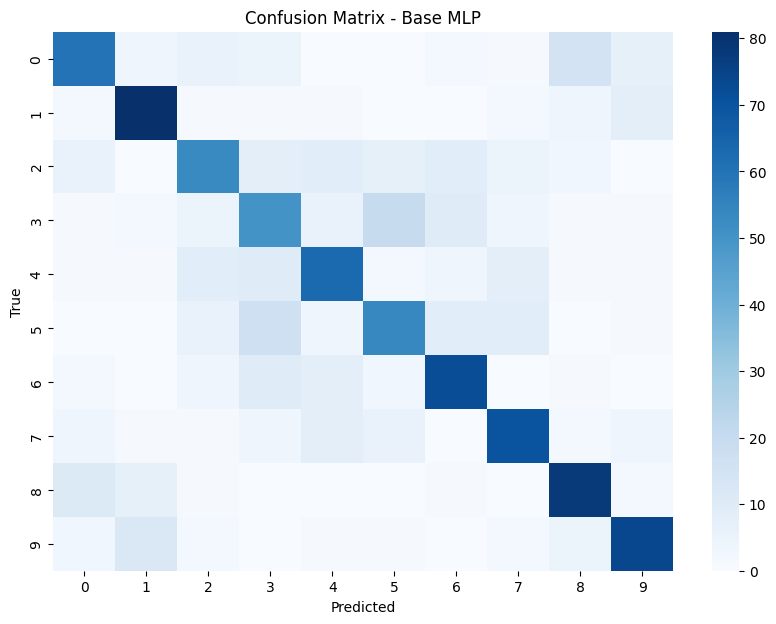

Precision (macro): 0.6536
Recall (macro):    0.6550

Precision per class:
[0.66666667 0.75       0.60227273 0.47619048 0.63       0.58064516
 0.6728972  0.69306931 0.70909091 0.75510204]

Recall per class:
[0.6  0.81 0.53 0.5  0.63 0.54 0.72 0.7  0.78 0.74]


In [ ]:
# ================================================
# 15. BASE MODEL EVALUATION: ACCURACY, CM, PRECISION, RECALL!!!!!!!!!
# ================================================

import torch
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score
)
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------
# 1. Generate predictions on the test set
# ------------------------------------------------
MLPModel.eval()
with torch.no_grad():
    logits_test = MLPModel(X_test_50)          # (1000, 10)
    preds_test = logits_test.argmax(dim=1)     # torch.Size([1000])
    preds_test_np = preds_test.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

# ------------------------------------------------
# 2. Accuracy
# ------------------------------------------------
accuracy = (preds_test_np == y_test_np).mean()
print(f"Accuracy: {accuracy:.4f}")

# ------------------------------------------------
# 3. Confusion Matrix
# ------------------------------------------------
cm = confusion_matrix(y_test_np, preds_test_np)
print("Confusion Matrix:\n", cm)

# If you want a heatmap:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix - Base MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ------------------------------------------------
# 4. Precision & Recall
# ------------------------------------------------
precision_macro = precision_score(y_test_np, preds_test_np, average="macro")
recall_macro = recall_score(y_test_np, preds_test_np, average="macro")

print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro):    {recall_macro:.4f}")

# Per-class precision & recall
precision_per_class = precision_score(y_test_np, preds_test_np, average=None)
recall_per_class = recall_score(y_test_np, preds_test_np, average=None)

print("\nPrecision per class:")
print(precision_per_class)

print("\nRecall per class:")
print(recall_per_class)
